# CS 109A/AC 209A/STAT 121A Data Science: Homework 7
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 9th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW7.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis 
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
import StringIO
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

Galvin, Owen

### Part (b): Course Number

CS 109a Extension

### Part (c): Who did you work with?

None

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Monitoring Land Cover Changes Using Satellite Images
In the face of rapid urban development and climate change, it is now more urgent than ever for governments (and other organizations) to have a detailed, accurate and up-to-date picture of land use and land cover, as well as how the land use/cover is changing over time, in order to make effective policy decision to manage and protect natural resources. Building such a comprehensive picture of land use/cover for a large region is extremely difficult. 

Recent improvements in satellite imagery and image process have allowed for new tools in land use/cover analysis. The following is an image of the change in vegetation cover around Belize from 1975 to 2007:

<img src="sat.jpg">

In this problem, we will explore how to use classifiers to detect the presence and location of vegetation in satellite images.


### Part 1(a): Detecting vegetation in satellite images

The following files contain sampled locations from satelite aeriel images: `dataset_1.txt`, ... `dataset_4.txt`. The first two columns contain the normalized latitude and longitude values. The last column indicates whether or not the location contains vegetation, with 1 indicating the presence of vegetaion and 0 indicating otherwise. 

These small sets of labels are typically generated by hand (that is, locations might be classified based on field studies or by cross-referencing with government databases). Your task is to use the labeled locations to train a model that will predict whether a new location is vegetation or non-vegetation.

- Suppose we were asked to write a computer program to automatically identify the vegetation regions on the landscape. How can we use the model fitting algorithms you have studied so far to identify the boundaries of the vegetation regions? In particular, discuss the suitability of the following algorithms for each of the four data sets (**you do not need to evaluate your classifier, build your argument using data and decision boundary visualizations**): 
    - linear or polynomial linear regression
    - linear or polynomial logistic regression
    - linear or quadratic discriminant analysis
    - decision trees

- By a quick visual inspection of each data set, what do you think is the smallest depth decision tree that would provide a good fit of the vegetation boundaries in each case? Does `sklearn`'s decision tree fitting algorithm always provide a good fit for the proposed depth? If not, explain why. **Support your answer with suitable visualization**.

We provide you with a function `plot_tree_boundary` to visualize a decision tree model on the data set.

In [2]:
#Load the data from satellite image #1 
sat_img_1 = pd.read_csv('datasets/dataset_1.txt', delimiter=',', header=None)
#Check out the data - sanity check
pd.concat([sat_img_1.head(), sat_img_1.tail()])

,0,1,2
0,0.566809,0.788130,1
1,0.400046,0.620933,1
2,0.458702,0.536935,1
3,0.474504,0.638224,1
4,0.558707,0.715527,1
495,0.812507,0.283802,0
496,0.527847,0.339417,0
497,0.554667,0.974403,0
498,0.311703,0.668797,0
499,0.325967,0.774477,0


In [3]:
#The data looks ok, so let's load the rest of the images
sat_img_2 = pd.read_csv('datasets/dataset_2.txt', delimiter=',', header=None)
sat_img_3 = pd.read_csv('datasets/dataset_3.txt', delimiter=',', header=None)
sat_img_4 = pd.read_csv('datasets/dataset_4.txt', delimiter=',', header=None)

#Make a list of the four dataframes so we can iterate through them later
sat_images = [sat_img_1, sat_img_2, sat_img_3, sat_img_4]

exploratory look at the raw data


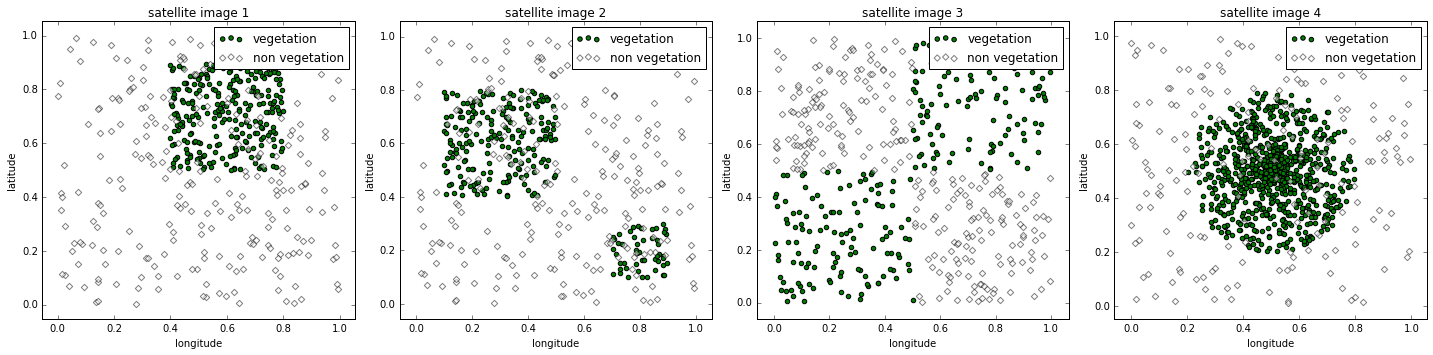

In [4]:
print 'exploratory look at the raw data'

#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]
    
    #Plot vegetation locations as green dots
    ax[i].scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation')
    #Plot non-vegetation locations as white dots
    ax[i].scatter(x[y == 0, 0], x[y == 0, 1], c='white', label='non vegetation', marker='D', alpha=.5)
    
    #Label everything
    ax[i].set_xlabel('longitude')
    ax[i].set_ylabel('latitude')
    ax[i].set_title('satellite image {}'.format(i + 1))
    ax[i].legend()
    ax[i].margins(x=0.05, y=0.05)
    
plt.tight_layout()
plt.show() 

In [5]:
# lab 8 code

#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (classifier)
#      poly_flag (fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='white', marker='D', alpha=.5)
    
    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)
    
    # here is my attempt to get the linear model to classify, using the mean value
    #  of all the predicted values as the dividing line between classifying as 0 vs. 1
    # and I didn't want to add another param so I did the un-pythonic isinstance
    #  guess I could have skipped that and run any model through my code, 0 would still remain 0 and 1, 1
    if isinstance(model, linear_model.LinearRegression):    
        yy_mean = np.mean(yy)
        def f(x):
            return 0 if x < yy_mean else 1
        f = np.vectorize(f)
        yy = f(yy)

    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [6]:
# Lab 8 code => function

def boundary_plots_from_model(model, title_prefix, shift_bounds=False, poly_flag=False):
    dataset_count = len(sat_images)
    #Plot the data in each dataframe as a subplot of a single figure
    fig, ax = plt.subplots(1, dataset_count, figsize=(25, 5))

    fig.suptitle(title_prefix, fontsize=20, y=1.02, x=0.2)
    
    #Iterate through the four images/dataframes
    for i in range(dataset_count):
        #Get the long/lat coords
        x = sat_images[i].values[:, :-1]
        #Get the class labels
        y = sat_images[i].values[:, -1]    

        if poly_flag:
            #Expand our predictor array with quadratic terms
            quad_features = preprocessing.PolynomialFeatures(degree = 2)
            x_expanded = quad_features.fit_transform(x)
            #Fit model with quadratic decision boundary
            model.fit(x_expanded, y)
        else:
            #Fit non-quadratic model
            model.fit(x, y)
    
        #Change the bounds on the scatter plot (the 4th dataframe needs a larger frame)
        if i == 3 and shift_bounds:
            bounds = (-0.5, 1.5)
        else:
            bounds = (0, 1)

        #Plot the data along with the decision boundary learned by our model
        ax[i] = plot_decision_boundary(x, y, model, 
                                       'satellite image {}'.format( i + 1), 
                                       ax[i], bounds, poly_flag)
        
    return fig


#logreg = linear_model.LogisticRegression()
#boundary_plots_from_model(logreg, 'Logistic Regression (linear)', shift_bounds=True)



Simple linear regression decision boundaries

Simple linear regression decision boundaries


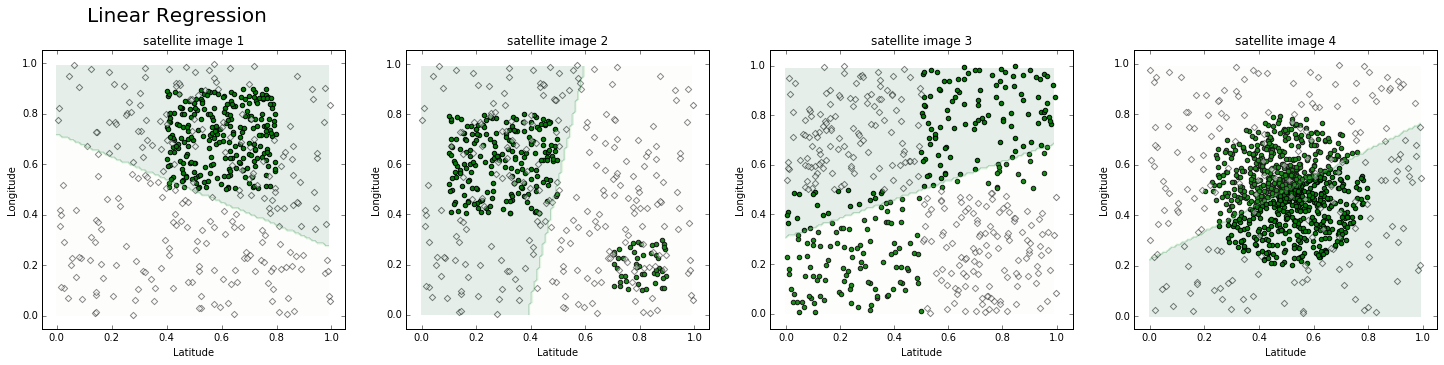

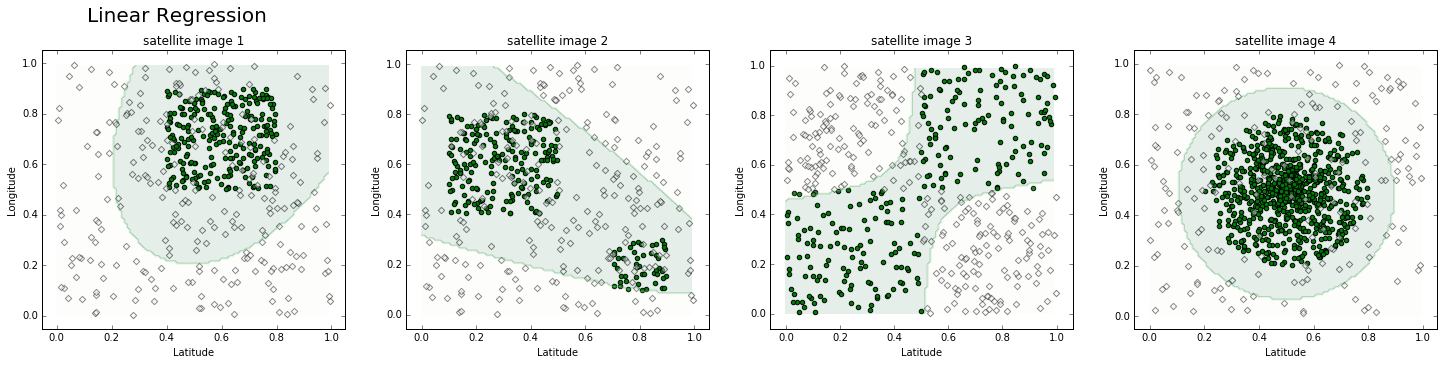

In [7]:
print
print 'Simple linear regression decision boundaries'

linreg = linear_model.LinearRegression()
boundary_plots_from_model(linreg, 'Linear Regression')

print
print 'Simple linear regression decision boundaries'

linreg = linear_model.LinearRegression()
boundary_plots_from_model(linreg, 'Linear Regression', poly_flag=True)

#plt.tight_layout()
plt.show()

Decision boundaries for various models, green shading indicates model will classify any point in that region as 
 


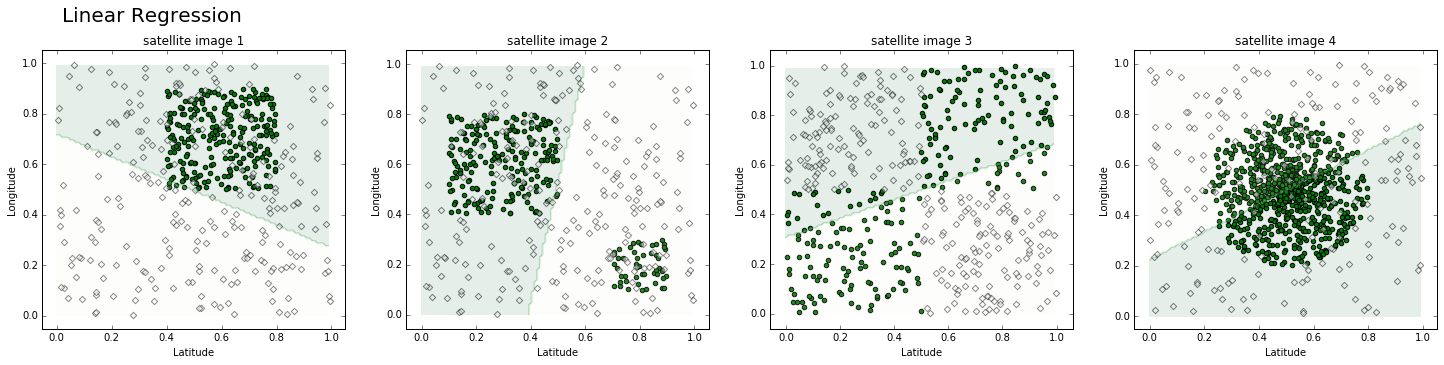

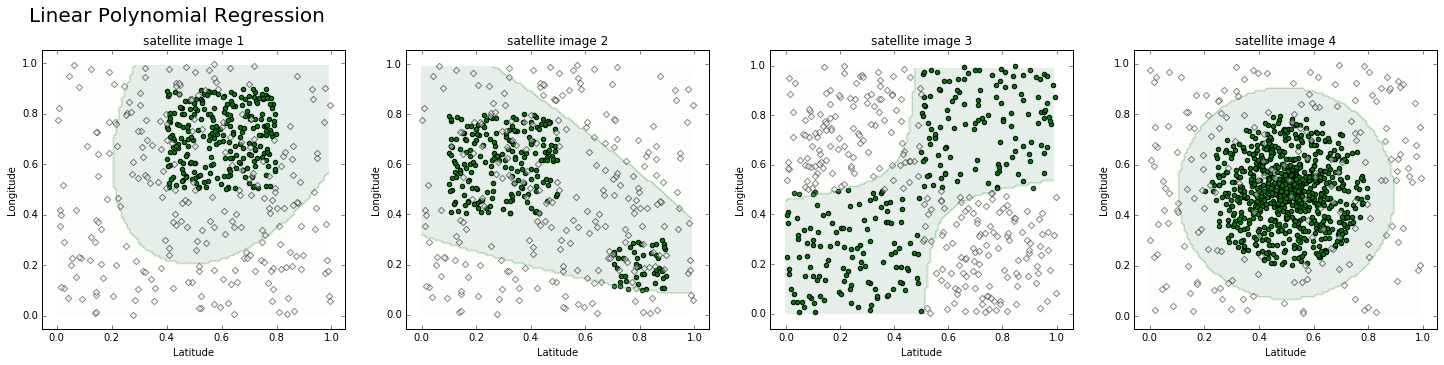

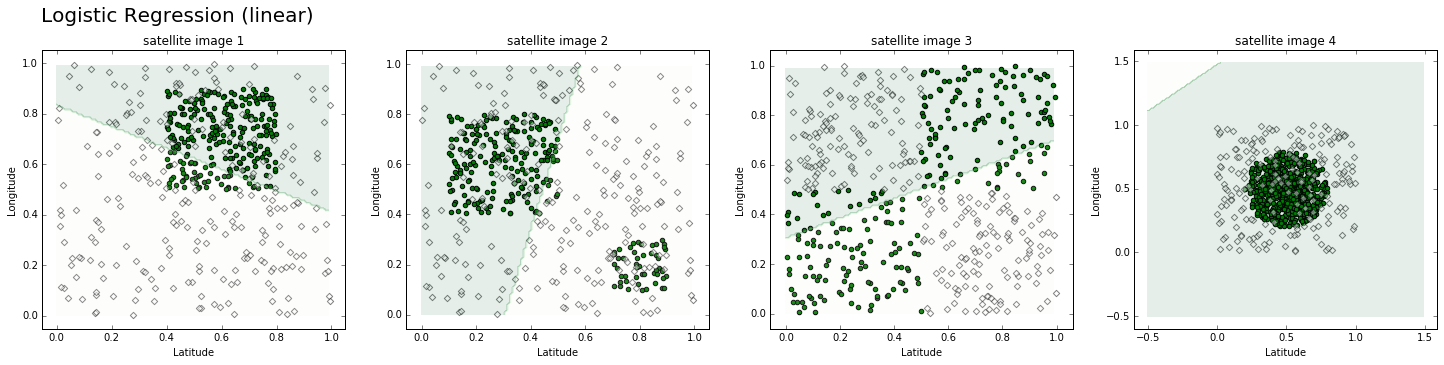

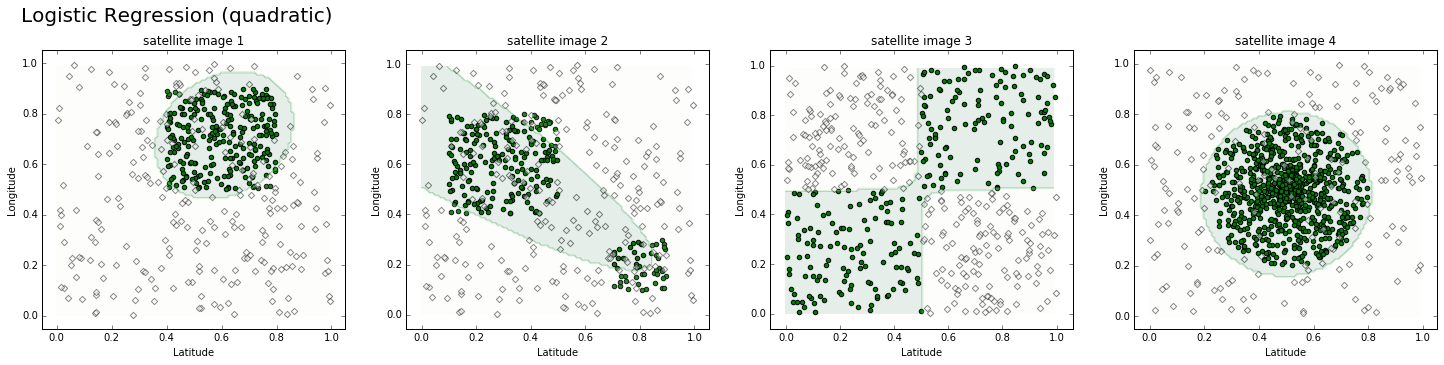

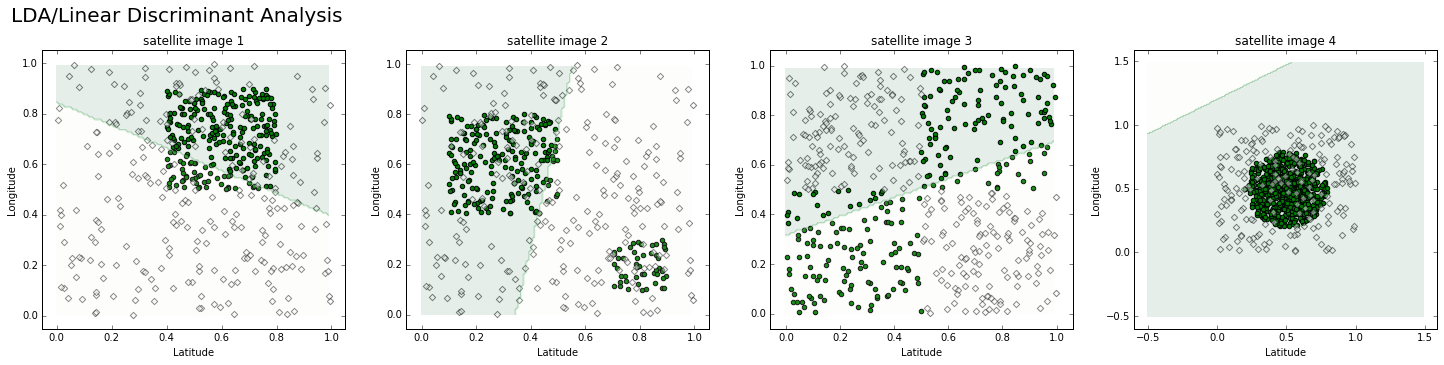

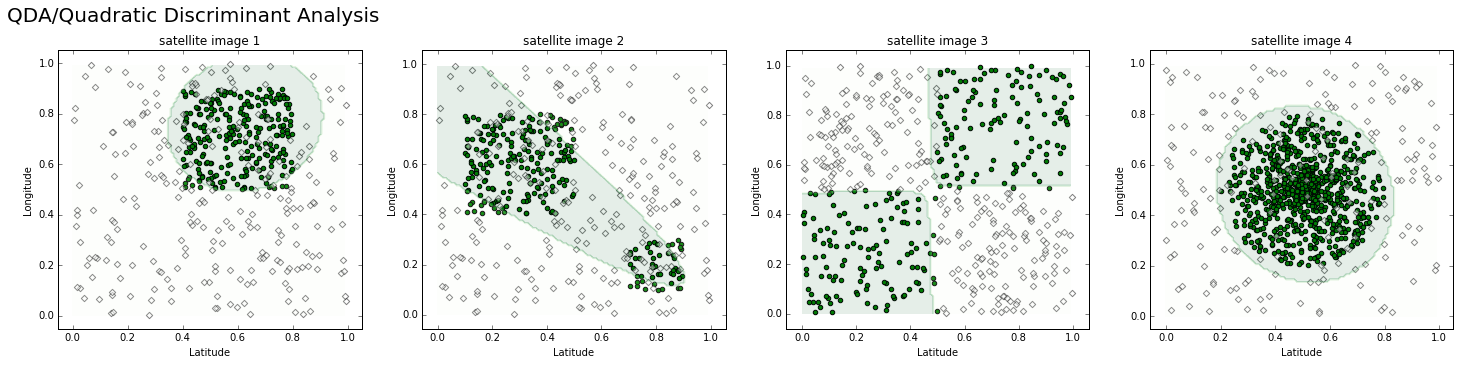

In [8]:
#plot all of the models one after the other, so they can easily be compared visually
print 'Decision boundaries for various models, green shading indicates model will classify any point in that region as '
print ' '

# the first two, the linear regression ones, have been forced into classifiers by comparing predictions vs. mean
linreg = linear_model.LinearRegression()
boundary_plots_from_model(linreg, 'Linear Regression        ')

linreg = linear_model.LinearRegression()
boundary_plots_from_model(linreg, 'Linear Polynomial Regression', poly_flag=True)


#Create a logistic regression model with linear boundary
logreg = linear_model.LogisticRegression()
boundary_plots_from_model(logreg, 'Logistic Regression (linear)', shift_bounds=True)

#Logistic Regression with Quadratic Terms
logreg_poly = linear_model.LogisticRegression(C=1000)
boundary_plots_from_model(logreg_poly, 'Logistic Regression (quadratic)', poly_flag=True)

# LDA
lda = discriminant_analysis.LinearDiscriminantAnalysis()
boundary_plots_from_model(lda, 'LDA/Linear Discriminant Analysis', shift_bounds=True)

#Logistic Regression with Quadratic Terms
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
boundary_plots_from_model(qda, 'QDA/Quadratic Discriminant Analysis')

plt.show()

Non-tree models first
#### Review of expected suitablity of each model to each of the four image datasets:
* Linear Regression
  * Classifies many correctly on image 1 but not very good overall, captures more vegetation vs. the Logistic Regression model but then also misclassifies more of the non-vegetation. The next are even more similar to Logistic Regression, and fare just as poorly. Image 4 is interesting - not good at all but intersting, where the model simply drew a straight line right through the circular data.
* Linear Polynomial Regression
  *  I had to decide how to approach the Linear Regression and so I'm reviewing these first two after having written out notes on the remaining models. Looking back to here from those models, we can see this one had results that were similar in shape to those of 'Logistic Regresssion with Quadratic effects', but with a distinctly poorer fit. As mentioned, the shapes are similar, but this model winds up with boundaries that are further away from the clusters of vegetation, including too many non-vegetative points in each case.
* Logistic Regression (linear)
 * Reasonable result on image 1, though perhaps that is more in comparison to how it did on the other images, which was quite poor. Not surprising considering the vegetation shapes involved vs. the limits of a straight line. For the circular vegetation region (image 4), predicted all points as vegetation. 
* Logistric Regresssion with Quadratic effects
 * My results differ from those in the downloaded lab, though if I clear & re-run the lab notebook locally, what I see there matches what I see in my output
 * And my results are actually quite good, this model appears to be quite accurate in all of the datasets except for 2, and even there the accuracy appears only a step or two below that found in the other images.
* LDA
 * Very similar, if not identical, results to those seen with linear logistic regression, meaning not-horrible on image1 and then rather-horrible on the remaining.
* QDA
 * Almost identical to performance of logistic regression w/quadratic effects ('LRQ'), and so rather good. Its ellipse in image 1 is a little broader than LRQ, i.e. not as accurate. But its boundary for image 2 reaches a bit more deeply into the small cluster vs. LRQ and thus appears to be superior there.


In [9]:
# now on to trees

#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (array of predictors)
#      y (array of labels)
#      model (the decision tree you want to visualize, already fitted)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax):
    # PLOT DATA
    ax.scatter(x[y==1,0], x[y==1,1], c='green')
    ax.scatter(x[y==0,0], x[y==0,1], c='white', marker='D', alpha=.5)
    
    # CREATE MESH
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [10]:
# Lab 8 code

#--------  fit_and_plot_dt
# Fit decision tree with on given data set with given depth, and plot the data/model
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)

def fit_and_plot_dt(x, y, depth, title, ax):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax)
    
    return ax

In [11]:
# Plot for dataset_1.txt: depths 1 to 5

def plot_trees_by_depth(dataset_idx, max_tree_depth, step=1):
    
    tree_depths = range(1, max_tree_depth+1, step)
    fig, ax = plt.subplots(1, len(tree_depths), figsize=(len(tree_depths)*5, 5))
    fig.suptitle('satellite image {}'.format(dataset_idx+1), fontsize=20, y=1.04, x=0.2)

    #Get the long/lat coords
    x = sat_images[dataset_idx].values[:, :-1]
    #Get the class labels
    y = sat_images[dataset_idx].values[:, -1]

    #Set an index for the subplots
    ind = 0
    #Iterate through various depths
    for i in tree_depths:
        #Plot data and decision boundary for decision tree model
        ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image {}'.format(i, dataset_idx+1), ax[ind]) 
        #Increment subplot index
        ind += 1
            
    return fig


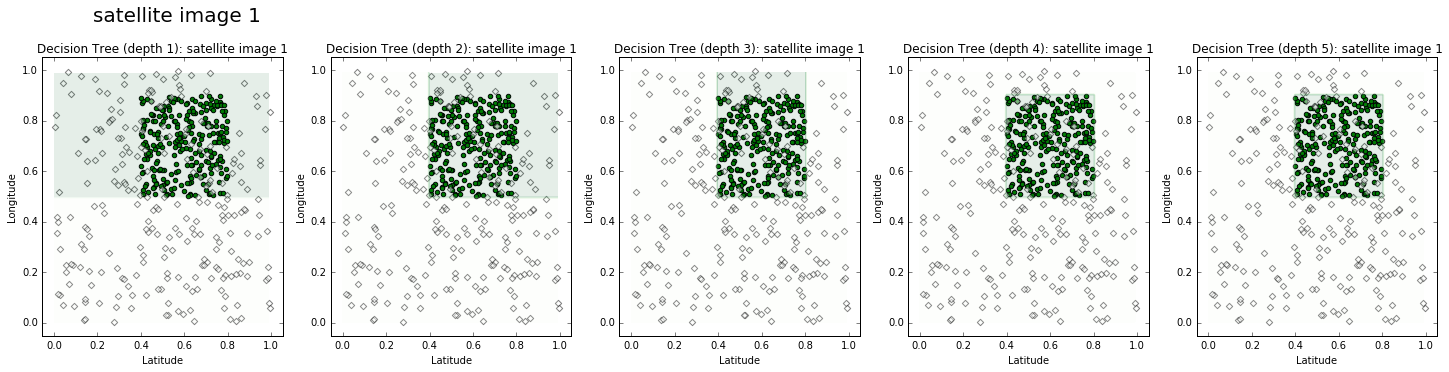

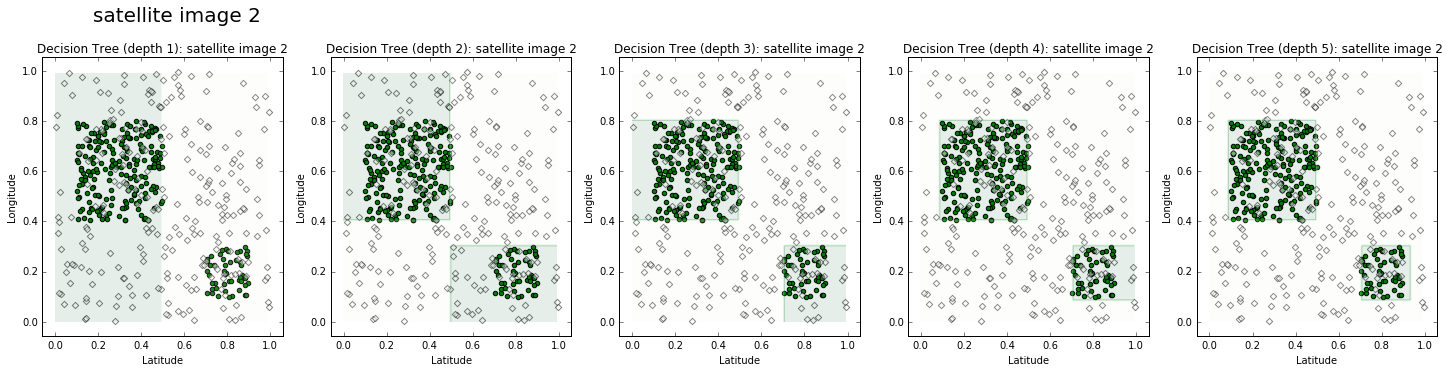

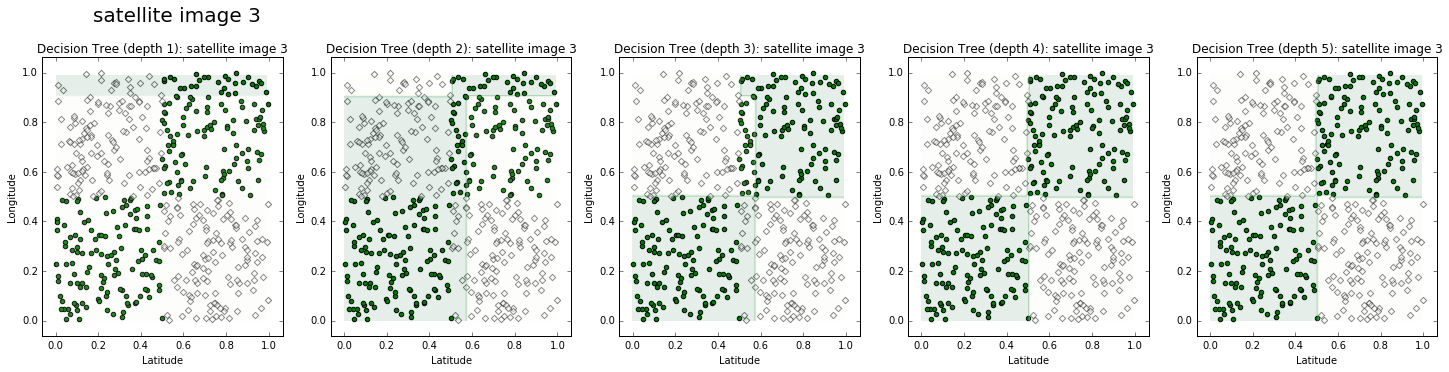

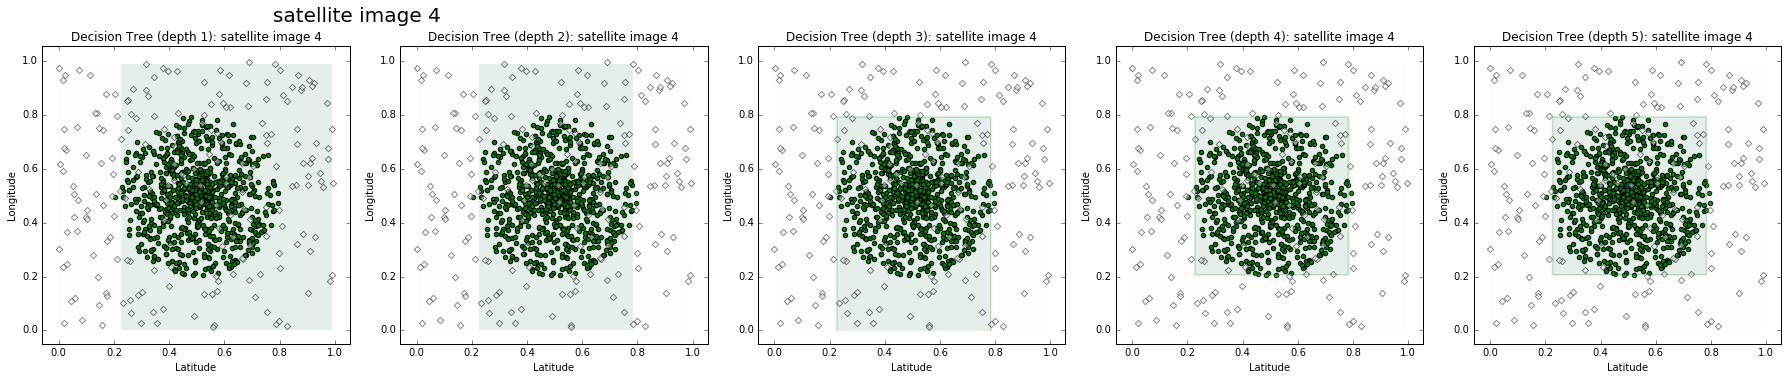

In [12]:
# plot decision boundaries for each of the datasets, for tree depths 1 to 5
for i in range(len(sat_images)):
    plot_trees_by_depth(i, 5)

plt.tight_layout()
plt.show()

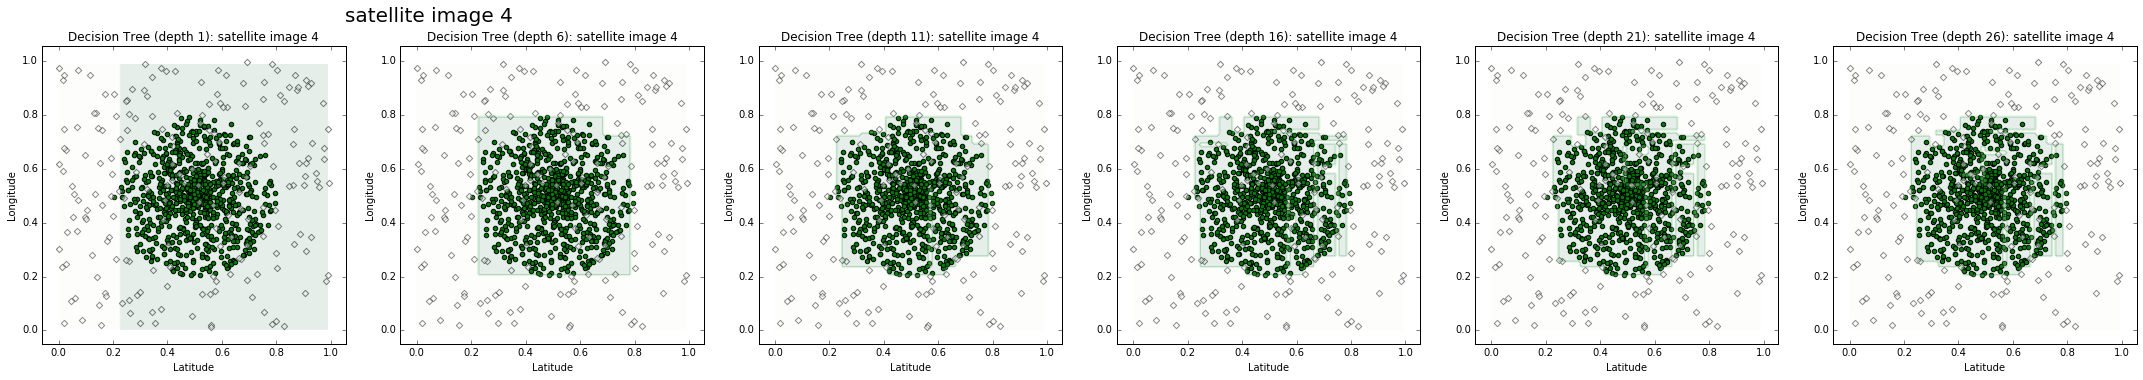

In [13]:
# circular nature of vegetation in dataset 4 will require greater tree depth, re-do that one, going deeper
plot_trees_by_depth(3, 27, 5)

plt.tight_layout()
plt.show()

Now a review of the tree models
#### Review of expected suitablity of each tree-model-depth l to each of the four image datasets:
Satellite image number
* 1
 * Model gets good results once it goes to depth = 4, where at that point it is able to define the 4 lines that make up a box that directly surrounds the vegatative points, which themselves are in the form of a rectangle.
* 2
 * Depth = 5 is where the two rectangular regions can be distinctly captured - each rectangle can be handled as in dataset 1, i.e. depth = 4. In this case the first split in the tree will divide the points into one of these two general regions. After that, a 4-level tree in each of those sub-nodes will be able to capture each of the two rectangles. 
* 3
 * Need to go to a depth=4 to get good results. Theoretically a depth of 2 would have been good enough to achieve the splits not displayed until a depth of 4 - there are really just two lines running straight across the two axes. Instead, the greedy nature of the decision tree algorithm (a practical necessity, computationally speaking) means it won't be until depth=4 that we get what we need.
* 4
 * This is the one with circular data, even at depth=5 we are basically coming up with a square box that includes many non-vegatative points in the proposed is-vegations classification. So we increase the depth, which definitely helps. And further increases will help also, at cost of computation. In the end though, woudl need a decision tree of infinite depth to perfectly match the data. Given practical limitations, the model doesn't improve much between depths of 12 - 26, so 11 may be a reasonable choice. 

### Part 1(b). What is the best splitting criterion for decision trees?
Suppose you are given a data set with 100 points in a satellite image, of which 51 are class 1 and 49 are class 0. Consider following two candidate splits for constructing a decision tree: 
1. [Part 1 = (Class 1: 11, Class 0: 37), Part 2 = (Class 1: 40, Class 0: 12)]
2. [Part 1 = (Class 1: 25, Class 0: 48), Part 2 (Class 1: 26, Class 0: 1)]

Which of these is a better split according classification error, Gini coefficient, and Entropy criteria? Do the three criteria agree on the best split, or is one better than the other? Support your answer with a concrete explanation.

In [14]:
# Lab 8 code
# Calculate classification accuracy for a binary split
def err(x1, x2):
    return min((x1,x2))

# Calculate Gini coefficient for a binary split
def Gini(x1, x2):
    return x1*(1-x1) + x2*(1-x2)

# Calculate Cross-entropy for a binary split
def entropy(x1, x2):
    return -x1*np.log(x1) - x2*np.log(x2)

# Split 1:

# Compute split counts
n11 = 48
n12 = 52
n1 = n11 + n12

# Compute split probabilities
x1 = 11./n11
x2 = 37./n11
y1 = 40./n12
y2 = 12./n12

print('Split 1')
print('Error = ' + str((n11*err(x1,x2)+n12*err(y1,y2))/n1))
print('Gini = ' + str((n11*Gini(x1,x2)+n12*Gini(y1,y2))/n1))
print('Entropy = ' + str((n11*entropy(x1,x2)+n12*entropy(y1,y2))/n1))

print('')

# Compute split counts
n21 = 73
n22 = 27
n2 = n21 + n22

# Split 2:
x1 = 25./n21
x2 = 48./n21
y1 = 26./n22
y2 = 1./n22

print('Split 2')
print('Error = ' + str((n21*err(x1,x2)+n22*err(y1,y2))/n2))
print('Gini = ' + str((n21*Gini(x1,x2)+n22*Gini(y1,y2))/n2))
print('Entropy = ' + str((n21*entropy(x1,x2)+n22*entropy(y1,y2))/n2))

Split 1
Error = 0.23
Gini = 0.354198717949
Entropy = 0.539274531592

Split 2
Error = 0.26
Gini = 0.348026382547
Entropy = 0.511910804521


Which of these is a better split according classification error, Gini coefficient, and Entropy criteria? Do the three criteria agree on the best split, or is one better than the other? Support your answer with a concrete explanation.

In terms of simple error measurement, Split 1 is superior as it has a lower rate vs. Split 2. But when it comes to decision tree splits, the purity of the split results is of greater importance and for that reason Split 2 is preferable since both the Gini and Entropy measurements indicate greater purity. These more-pure splits will allow the tree to be pruned more effectively.


## Problem 2: Loan Risk Assessment
In this problem, you are asked by an Unamed National Bank to build a risk assessment model that predicts whether or not it is risky to give a loan to an applicant based on the information provided in their application. Traditionally, loan applications are processed and assessed by hand, but now the bank wants to move to an automated loan processing system. That is, the bank will provide you with loan applications that it has processed in the past for you to build a classifier for risk assessment, going forward, the bank will reject the loan applications from applicants labeled risky and approve the applications that are labeled safe by your model.

The relevant training and test sets are provided in the files: `dataset_5_train.txt` and `dataset_5.test.txt`. The training and testing sets are created from both approved and rejected loan applications that the bank has processed by hand in the past. The first 24 columns contain attributes for each applicant gathered from their application, and the last column contains the credit risk assessment with 1 indicating that the customer is a loan risk, and 0 indicating that the customer is not a loan risk. The names of the attributes are provided in the file `dataset_5_description.txt`.


### Part 2(a): A simple decision tree model
- Fit a simple decision tree of depth 2 to the training set and report its accuracy on the test set. 

- Interpret the way your model performs risk classifcation. Would you recommend this classifier to Unamed National Bank for making decisions on the loan applications of **real people**? If yes, make an argument for the merrits of this classifer. If no, then make necessary changes to the data set and fit a new classifier that you believe is fair to use in practice, then compare the two classifiers.


We have provided you with a function `display_dt` to display the structure of the decision tree in DOT format.

In [15]:
# Print decision tree model 'model', already fitted
def display_dt(model):
    dummy_io = StringIO.StringIO() 
    tree.export_graphviz(model, out_file = dummy_io) 
    print dummy_io.getvalue()

In [16]:
# load in both datasets, using nomenclature from description.txt file
predictors = ['X{}'.format(i) for i in range(24)]
label = ['is_loan_risk']
train = pd.read_csv('datasets/dataset_5_train.txt', delimiter=',', header=None, names=predictors+label)
test = pd.read_csv('datasets/dataset_5_test.txt', delimiter=',', header=None, names=predictors+label)
# take a peek
train.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,is_loan_risk
0,3288,20000,2,1,2,39,0,0,0,0,...,19308,19498,0,1588,1770,1200,390,0,44334,1
1,3001,50000,1,2,2,27,2,2,0,0,...,7382,1975,50514,4146,1200,0,0,49800,0,1
2,3288,80000,1,2,2,27,1,2,2,2,...,68531,69808,70544,5000,3100,2000,3000,2000,4000,1
3,3652,70000,2,2,2,22,0,0,0,0,...,69316,29083,28140,3200,3600,3075,1204,1200,1046,0
4,3817,200000,1,1,2,24,-1,-1,-1,-1,...,18154,13677,2018,200,198,18156,0,1150,0,0


In [17]:
# some basic checks for missing values, in train
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 25 columns):
X0              250 non-null float64
X1              250 non-null float64
X2              250 non-null float64
X3              250 non-null float64
X4              250 non-null float64
X5              250 non-null float64
X6              250 non-null float64
X7              250 non-null float64
X8              250 non-null float64
X9              250 non-null float64
X10             250 non-null float64
X11             250 non-null float64
X12             250 non-null float64
X13             250 non-null float64
X14             250 non-null float64
X15             250 non-null float64
X16             250 non-null float64
X17             250 non-null float64
X18             250 non-null float64
X19             250 non-null float64
X20             250 non-null float64
X21             250 non-null float64
X22             250 non-null float64
X23             250 non-null float64
is_loan

In [18]:
# now in test
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9750 entries, 0 to 9749
Data columns (total 25 columns):
X0              9750 non-null float64
X1              9750 non-null float64
X2              9750 non-null float64
X3              9750 non-null float64
X4              9750 non-null float64
X5              9750 non-null float64
X6              9750 non-null float64
X7              9750 non-null float64
X8              9750 non-null float64
X9              9750 non-null float64
X10             9750 non-null float64
X11             9750 non-null float64
X12             9750 non-null float64
X13             9750 non-null float64
X14             9750 non-null float64
X15             9750 non-null float64
X16             9750 non-null float64
X17             9750 non-null float64
X18             9750 non-null float64
X19             9750 non-null float64
X20             9750 non-null float64
X21             9750 non-null float64
X22             9750 non-null float64
X23             975

In [19]:
# function to print some basic stats about each variable
# didn't see any problems in train/test so but there was talk in Piazza of missing values
def print_stats(df):
    fmt = '{:<30}{:<10}{:<10}{:>12}{:>20}{:>20}'
    fmt_numbers = '{:<30}{:<10}{:<10}{:>12,.4f}{:>20,.4f}{:>20,.4f}'

    print fmt.format('', 'missing', 'missing', '', '', '')
    print fmt.format('column', 'ALL?', 'ANY?', 'min', 'max', 'mean')
    print '-----------------------------------------------------------------------------------------------------------------'
    #alpha_dtypes = sorted(dtype_dict.items(), key = lambda item: item[0])
    count = 0
    for col in predictors:
        count += 1
        all_empty = df[col].isnull().values.all()
        all_empty = df[col].isnull().values.any()
        if all_empty:
            min_val, max_val, mean_val = 'n.a.','n.a.','n.a'
            line = fmt.format(col, str(all_empty), str(all_empty), min_val, max_val, mean_val)
        else:
            #print data_type
            stats = df[col].describe()            
            min_val, max_val, mean_val = stats['min'], stats['max'], stats['mean']
            line = fmt_numbers.format(col, str(all_empty), str(all_empty), min_val, max_val, mean_val)
        print line

            
    print            
    print '{} columns summarized'.format(count)


In [20]:
# further details about train
print_stats(train)

                              missing   missing                                                       
column                        ALL?      ANY?               min                 max                mean
-----------------------------------------------------------------------------------------------------------------
X0                            False     False       3,001.0000          3,827.0000          3,403.6280
X1                            False     False      10,000.0000        550,000.0000        159,080.0000
X2                            False     False           1.0000              2.0000              1.5360
X3                            False     False           1.0000              6.0000              1.9120
X4                            False     False           1.0000              3.0000              1.6200
X5                            False     False          22.0000             69.0000             34.7120
X6                            False     False          -2.0000

In [21]:
# and test, never did find any that popped out
print_stats(test)

                              missing   missing                                                       
column                        ALL?      ANY?               min                 max                mean
-----------------------------------------------------------------------------------------------------------------
X0                            False     False       3,001.0000          3,827.0000          3,399.3461
X1                            False     False      10,000.0000        760,000.0000        154,596.6851
X2                            False     False           1.0000              2.0000              1.5872
X3                            False     False           0.0000              6.0000              1.8667
X4                            False     False           0.0000              3.0000              1.5421
X5                            False     False          21.0000             75.0000             35.5514
X6                            False     False          -2.0000

In [22]:
x_train = train[predictors].values
y_train = train[label].values

x_test = test[predictors].values
y_test = test[label].values

depth = 2
dt = tree.DecisionTreeClassifier(max_depth = depth)
dt.fit(x_train, y_train)

accuracy = dt.score(x_test, y_test)
print 'naive decision tree with depth = {} has an accuracy of approximately {:.2f}%'.format(depth, accuracy*100)

naive decision tree with depth = 2 has an accuracy of approximately 88.06%


In [23]:
# crude display of decision tree
display_dt(dt)

digraph Tree {
node [shape=box] ;
0 [label="X[0] <= 3293.0\ngini = 0.4997\nsamples = 250\nvalue = [122, 128]"] ;
1 [label="X[2] <= 1.5\ngini = 0.1338\nsamples = 111\nvalue = [8, 103]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.2563\nsamples = 53\nvalue = [8, 45]"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 58\nvalue = [0, 58]"] ;
1 -> 3 ;
4 [label="X[0] <= 3822.0\ngini = 0.295\nsamples = 139\nvalue = [114, 25]"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.2159\nsamples = 130\nvalue = [114, 16]"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 9\nvalue = [0, 9]"] ;
4 -> 6 ;
}


In [24]:
# started going down the path of installing graphviz etc. but wasn't finding a decent solution that would
#  run properly on different platforms/environments

# so lets confirm what I think I see by doing a tree depth of 1
dt_1 = tree.DecisionTreeClassifier(max_depth = (1))
dt_1.fit(x_train, y_train)

display_dt(dt_1)

digraph Tree {
node [shape=box] ;
0 [label="X[0] <= 3293.0\ngini = 0.4997\nsamples = 250\nvalue = [122, 128]"] ;
1 [label="gini = 0.1338\nsamples = 111\nvalue = [8, 103]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.295\nsamples = 139\nvalue = [114, 25]"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
}


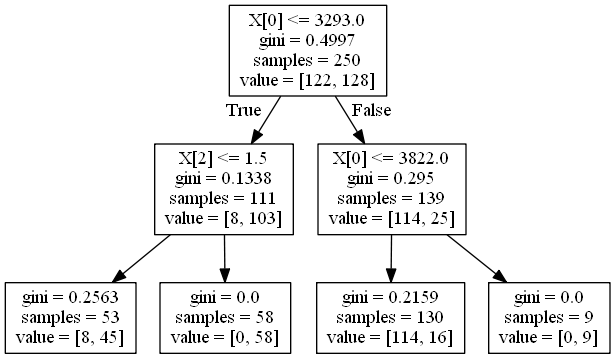

In [25]:
# ok, in the end, really need a pic to interpret
from IPython.display import Image
pic = Image('mytree.png')
pic

Ok, my take from above is that the first split is on X[0], i.e. the first columns, which had named as X0. That translates per the description.txt file as Census code. Likewise, the other variable used by the tree is X[2] (X2), which is for Gender (1 = male; 2 = female).
So the tree says: 
1) if Census Code <= 3293
  a) if Gender is <= 1.5, i.e. is male, then the loan is risky
  b) else if Gender is female, loan is not risky
2) else if Census Code > 3293
  a) if Census Code <= 3822, loan is risky
  b) else if Census Code > 3822, loan is not risky
  
*I ininitially thought Census code referred to a census block, i.e. where people live, so I discussed redlining etc. After finding out I was simply wrong via Piazza, I've hopefully cleaned up my text to remove that misconception, and some of my illustrative data displays.*


In [26]:
print '''
I originally did the below to show how much effect the census code value had on the is_loan_risk outcome. I suppose that 
is still a valid concern but is not at this point reason enough to do something as drastic as removing X0 from 
consideration. On the other hand, the ratios are so extreme as to raise warning flares. I feel I would need to know what 
some of the occupations were in order to further weigh my options.
'''
train.groupby('X0')['is_loan_risk'].agg({'loan_riskiness_ratio': 'mean'}).sort_index()


I originally did the below to show how much effect the census code value had on the is_loan_risk outcome. I suppose that 
is still a valid concern but is not at this point reason enough to do something as drastic as removing X0 from 
consideration. On the other hand, the ratios are so extreme as to raise warning flares. I feel I would need to know what 
some of the occupations were in order to further weigh my options.



,loan_riskiness_ratio
X0,
3001,0.961538
3123,0.954545
3288,0.904762
3298,0.125000
3420,0.000000
3530,0.052632
3540,1.000000
3585,0.142857
3652,0.000000


In [27]:
print '''
Similar to above, with more information but less interpretable without careful review. This one also includes the Gender 
value as X2, with 1 = male and 2 = female. And here se that gender appears to be reasonably well distributed amongst the
census codes, such that the codes do not serve as a direct proxy for gender, i.e. one of the codes is not for midwife at 
one extreme, or for brickmason at the other.
'''
train.groupby(['X0', 'X2'])['is_loan_risk'].agg({'loan_riskiness_ratio': 'mean', 'num_people': 'count'} )


Similar to above, with more information but less interpretable without careful review. This one also includes the Gender 
value as X2, with 1 = male and 2 = female. And here se that gender appears to be reasonably well distributed amongst the
census codes, such that the codes do not serve as a direct proxy for gender, i.e. one of the codes is not for midwife at 
one extreme, or for brickmason at the other.



num_people  loan_riskiness_ratio
X0   X2                                  
3001 1           11              0.909091
     2           15              1.000000
3123 1           10              0.900000
     2           12              1.000000
3288 1           32              0.812500
     2           31              1.000000
3298 1           14              0.214286
     2           10              0.000000
3420 1            3              0.000000
     2           11              0.000000
3530 1            4              0.250000
     2           15              0.000000
3540 1            1              1.000000
     2            1              1.000000
3585 1           13              0.153846
     2           15              0.133333
3652 1            7              0.000000
     2            9              0.000000
3662 1            2              1.000000
     2            1              1.000000
3817 1           14              0.142857
     2           10              0.100000
3827 1            5              1.000000
     2            4              1.000000

The upshot of all this is that the naive tree model directly uses gender as one of the main determinants as to whether or not a loan is risky. And if we remove that, another undesirable variable may become involved in the tree creation. Either way, given current conditions in the United States<sup>1</sup>, at this moment I'm going to assume we are talking about Canada when deciding whether or not the model is acceptable or not.

<sup>1</sup> I'm writing on Monday, November 7th, cultural norms are somewhat in flux.  
update: confirmed, all fluxed up, Canada was a wise choice

And for Canadian **real people** the decision should be to throw this model in the garbage and create a new one that excludes certain demographic information such as Gender. 

Per the Canadian Human Rights Commission, via http://www.chrc-ccdp.gc.ca/eng/content/what-discrimination:

> These 11 grounds are protected under the Canadian Human Rights Act: 
- race 
- national or ethnic origin 
- colour 
- religion 
- age 
- sex 
- sexual orientation 
- marital status 
- family status 
- disability 
- a conviction for which a pardon has been granted or a record suspended.

The next step will involve scrubbing the data/dataframe of the potentially discriminating information


In [28]:
discriminatory_var = [
    'X2', #Gender
    'X4', #Marital status
    'X5', #Age
]

keep_columns = [col for col in train.columns.values if col not in discriminatory_var]
train_new = train[keep_columns]
test_new = test[keep_columns]

# pull out the dependent variable, is_loan_risk, from the columns we are keeping
predictors_new = keep_columns[:-1]
x_train_new = train_new[predictors_new].values
y_train_new = train_new[label].values

x_test_new = test_new[predictors_new].values
y_test_new = test_new[label].values

depth = 2
dt_new = tree.DecisionTreeClassifier(max_depth = depth)
dt_new.fit(x_train_new, y_train_new)

# for safety, reset accuracy variable to score from initial model
accuracy = dt.score(x_test, y_test)
print 'naive decision tree with depth = {} has an accuracy of approximately {:.2f}%'.format(depth, accuracy*100)
print
accuracy_new = dt_new.score(x_test_new, y_test_new)
print 'Canadian decision tree with depth = {} has an accuracy of approximately {:.2f}%'.format(depth, accuracy_new*100)
print
print "The model's overall accuracy for sure seems to remain unchanged between the two. I'm hoping that is expected "
print " behavior and I didn't miss updating a variable update somehere."


naive decision tree with depth = 2 has an accuracy of approximately 88.06%

Canadian decision tree with depth = 2 has an accuracy of approximately 88.06%

The model's overall accuracy for sure seems to remain unchanged between the two. I'm hoping that is expected 
 behavior and I didn't miss updating a variable update somehere.


In [29]:
# crude display of decision tree
display_dt(dt_new)

digraph Tree {
node [shape=box] ;
0 [label="X[0] <= 3293.0\ngini = 0.4997\nsamples = 250\nvalue = [122, 128]"] ;
1 [label="X[14] <= 169391.0\ngini = 0.1338\nsamples = 111\nvalue = [8, 103]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.1068\nsamples = 106\nvalue = [6, 100]"] ;
1 -> 2 ;
3 [label="gini = 0.48\nsamples = 5\nvalue = [2, 3]"] ;
1 -> 3 ;
4 [label="X[0] <= 3822.0\ngini = 0.295\nsamples = 139\nvalue = [114, 25]"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.2159\nsamples = 130\nvalue = [114, 16]"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 9\nvalue = [0, 9]"] ;
4 -> 6 ;
}


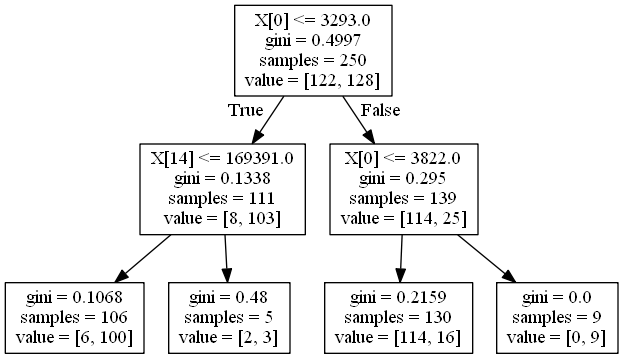

In [30]:
#tree.export_graphviz(dt_new, out_file="CA_mytree.dot")
from IPython.display import Image
pic = Image('CA_mytree.png')
pic

In [31]:
print 'translation matrix between new column index and remaining column names'
#zip(['X[{}]'.format(i) for i in range(len(train_new.columns))], predictors_new)
[('X[{}]'.format(i), c) for i, c in enumerate(predictors_new)]

translation matrix between new column index and remaining column names


[('X[0]', 'X0'),
 ('X[1]', 'X1'),
 ('X[2]', 'X3'),
 ('X[3]', 'X6'),
 ('X[4]', 'X7'),
 ('X[5]', 'X8'),
 ('X[6]', 'X9'),
 ('X[7]', 'X10'),
 ('X[8]', 'X11'),
 ('X[9]', 'X12'),
 ('X[10]', 'X13'),
 ('X[11]', 'X14'),
 ('X[12]', 'X15'),
 ('X[13]', 'X16'),
 ('X[14]', 'X17'),
 ('X[15]', 'X18'),
 ('X[16]', 'X19'),
 ('X[17]', 'X20'),
 ('X[18]', 'X21'),
 ('X[19]', 'X22'),
 ('X[20]', 'X23')]

### Part 2(b): An ensemble of decision trees

- One way to improve the prediciton accuracy for this task is to use an ensemble of decision trees fitted on random samples, as follows: given a training set of size $n$, sample new training sets uniformly with replacement, and fit a decision tree model on each random sample.

  Now, how would you combine the ensemble into a single classifier? There are at lease two ways:

   - *Random classifier*: predict using a randomly chosen decision tree from the ensemble
   - *Majority classifier*: predict using the majority vote from decision trees in the ensemble
   
   

- We can also fit a *Random Forest* model for our data (`sklearn.ensemble.RandomForestClassifier`).

Is there a significant difference in the prediction accuracies of the above three approaches on the loan data set? If so, explain why.


**Note:**  The Random Forest approach can easily overfit the training set. What are the important parameters in `sklearn`'s Random Forest fitting function that influence the model fit? For the risk assessment task, you **need** to fit your random forest model by using a suitable model selection procedure to tune these parameters.





In [32]:
# begin with my own implementation of the ensemble of decision trees

def bootstrapped_trees(X, Y, bags, d=1000):

    n = len(X)
    #models = pd.DataFrame()
    predictions = np.zeros([bags, n])
    test_errors = np.zeros([bags, n])
    for b in range(bags):
        # Generate a list of indices 0 to n and permute it
        perm =np.random.randint(low=0, high=n, size=n) 
        not_chosen = list(set(range(n)).difference(set(perm)))
        x_subsample = X[perm] 
        y_subsample = Y[perm] 

        dt = tree.DecisionTreeClassifier(max_depth = d)
        dt.fit(x_subsample, y_subsample)
        predictions[b] = dt.predict(X)

        dt_oob = tree.DecisionTreeClassifier(max_depth = d)
        dt_oob.fit(x_train_new[not_chosen], y_train_new[not_chosen])
        test_errors[b] = dt_oob.score(x_train_new[not_chosen], y_train_new[not_chosen])

    return predictions, test_errors


In [38]:
predictions, test_errors = bootstrapped_trees(x_train_new, y_train_new, bags=101)

# and then here is where it falls down, I'm not sure what the conceptual leap is from creating
#  my ensemble to being able to actually use it on test data

random_bag_idx = np.random.randint(low=0, high=len(predictions))
random_tree_score = np.mean(y_train_new.ravel() == predictions[random_bag_idx])
print 'Random classifier error rate: {}'.format(1-random_tree_score)

# majority by simple rounding of average of predictions - predictors are 0 or 1, making life much easier
majority_predictions = np.round(np.mean(predictions, axis=0))
ensemble_score = np.mean(y_train_new.ravel() == majority_predictions)
print 'Majority classifier error rate: {}'.format(1 - ensemble_score)


Random classifier error rate: 0.06
Majority classifier error rate: 0.0


scratch that effort, go to scikit-learn

In [34]:
# ok, lets try scikit-learn's BaggingClassifier
n_folds = len(predictors_new)
n = len(x_train_new)
seed = 789
kf = KFold(n=n, n_folds=n_folds, random_state=seed)
num_trees = 11
bc_model = ensemble.BaggingClassifier(n_estimators=num_trees, random_state=seed)
scores = cross_val_score(bc_model, x_train_new, y_train_new.ravel(), cv=kf)

rs = np.random.RandomState(seed)
random_bag_idx = rs.randint(low=0, high=len(scores))
random_tree_score = scores[random_bag_idx]
print 'Random classifier error rate: {:.4f}'.format(1 - random_tree_score)
print 'Majority classifier error rate: {:.4f}'.format(1 - scores.mean())


Random classifier error rate: 0.1818
Majority classifier error rate: 0.1201


min test training error rate: 0.134358974359


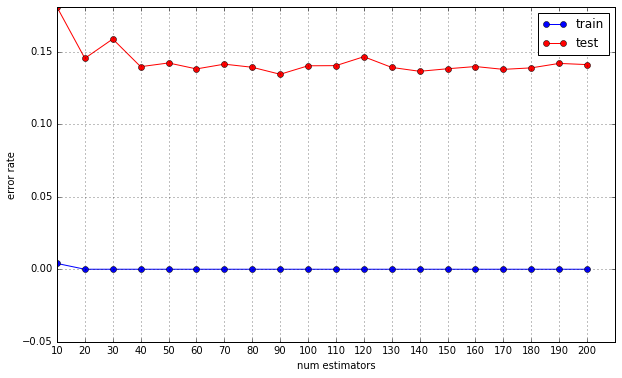

In [39]:
# max_depth, prof usually uses full-grown trees, leave that param at default = full-grown

# run through a number of tree sizes, ranging from 10 to 200, in 10-count intervals

#RandomForestClassifier default max_features=sqrt(n_features)
m_value = int(np.sqrt(len(predictors_new))) # i.e. 4, 
num_estimator_range = range(10,201,10)

train_err_rates = np.zeros([len(num_estimator_range), 1])
test_err_rates = np.zeros([len(num_estimator_range), 1])

for idx, num_est in enumerate(num_estimator_range):
    
    rf = RandomForestClassifier(n_estimators=num_est, max_features=m_value, oob_score=True)
    rf_model = rf.fit(x_train_new, y_train_new.ravel())
    
    rf_train_score = rf.score(x_train_new, y_train_new)
    rf_test_score = rf.score(x_test_new, y_test_new)

    train_err_rates[idx] = 1-rf_train_score
    test_err_rates[idx] = 1-rf_test_score

print 'min test training error rate: {}'.format(np.min(test_err_rates))

plt.figure(figsize=(10,6))
plt.plot(train_err_rates, 'bo-', label=r'train')
plt.plot(test_err_rates, 'ro-', label=r'test')
plt.ylim([-0.05, np.max(test_err_rates)])
plt.xticks(range(len(num_estimator_range)), num_estimator_range)
plt.xlabel('num estimators')
plt.ylabel('error rate')
plt.legend(loc='best')
plt.grid()    


min test training error rate: 0.121128205128


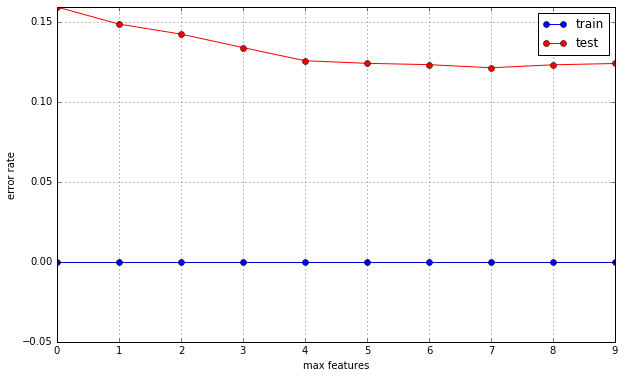

In [36]:
# max_depth, prof usually uses full-grown trees, leave that param at default = full-grown

# now run with different n_estimators, see if that makes much of a difference

num_estimators_value = 90
m_base = int(np.sqrt(len(predictors_new))) # i.e. 4, default used by scikit
m_range = range(m_base/2, m_base*3)
train_err_rates = np.zeros([len(m_range), 1])
test_err_rates = np.zeros([len(m_range), 1])

for idx, m in enumerate(m_range):
    
    rf = RandomForestClassifier(n_estimators=num_estimators_value, max_features=m, oob_score=True)
    rf_model = rf.fit(x_train_new, y_train_new.ravel())
    
    rf_train_score = rf.score(x_train_new, y_train_new)
    rf_test_score = rf.score(x_test_new, y_test_new)

    train_err_rates[idx] = 1-rf_train_score
    test_err_rates[idx] = 1-rf_test_score

print 'min test training error rate: {}'.format(np.min(test_err_rates))

plt.figure(figsize=(10,6))
plt.plot(train_err_rates, 'bo-', label=r'train')
plt.plot(test_err_rates, 'ro-', label=r'test')
plt.ylim([-0.05, np.max(test_err_rates)])
plt.xlabel('max features')
plt.ylabel('error rate')
plt.legend(loc='best')
plt.grid()    

In terms of comparison, the Random Classifier to have an error rate that was... random. It of course could go up or down depending on the run but the Majority Classifier was a solid choice, clocking in at around a 12% error rate. Then the Random Forest, once it was run with a reasonable number of trees and max_features, had a very similar rate. Presumably with a more complicated set of data the Random Forest would have been distinctly superior but I didn't see that here.
              

## Challenge Problem: Boosting for Classification

We've seen in class that boosting is a useful ensemble method to combine a collection of simple regression trees into a powerful regression model. Chapter 10.1 of the text book ([*J.H. Friedman, R. Tibshirani, and T. Hastie, "The Elements of Statistical Learning"*](http://statweb.stanford.edu/~tibs/ElemStatLearn/)) describes the boosting technique for classification trees. Implement the method from scratch.
    
Write a function `fit_and_score_boosted_trees` satisfying:
- Input:
    - `x_train`:  Array of predictors in training set
    - `y_train`:  Array of binary responses in training set
    - `x_test`:  Array of predictors in training set
    - `y_test`:  Array of binary responses in training set
    - `M`:  Number of iterations / Number of decision trees in the ensemble
    - `depth`:  Depth of each decision tree
- Fits an ensemble of `T` decision trees to the training set
- Output:
    - `test_accuracy`:  classification accuracy of the ensemble on the test set

Your function will also have to **standardise** the predictors in the training and test sets before applying boosting.
   
**Hints:** 
- `sklearn`'s decision tree learning routine has an option to specific weights on the training points
- `sklearn`'s classifiers make predictions in {0,1} while the book assumes predictions in {-1, 1}

Your implementation will be evaluated based on three test cases: 

`challenge_testcase_1_train.txt`, `challenge_testcase_1_test.txt`

`challenge_testcase_2_train.txt`, `challenge_testcase_2_test.txt`

`challenge_testcase_3_train.txt`, `challenge_testcase_3_test.txt`

These cases represent extreme examples of data (each dataset contains a particular type of pathology) that might break an implementaiton that is not carefully thought through. 

**Run the code given below to test your implementation. Call `test_implementation` and pass it your function `fit_and_score_boosted_trees`.**

In [37]:
#--------  test_implementation
# A function that tests your fit_and_score_boosted_trees function using three test sets.
# Input: 
#      fit_and_score_boosted_trees (your implementation of the boosting function)
# Returns: 
#      None

def test_implementation(fit_and_score_boosted_trees):
    
    # Iterate over test cases
    for i in range(1,4):
        # Load train & test data
        data_train = np.loadtxt('testcases/challenge_testcase_' + str(i) + '_train.txt', delimiter=',')
        data_test = np.loadtxt('testcases/challenge_testcase_' + str(i) + '_test.txt', delimiter=',')

        # Split label and instances
        y_train = data_train[:,-1]
        x_train = data_train[:,0:-1]

        y_test = data_test[:,-1]
        x_test = data_test[:,0:-1]

        # Run boosting function
        print 'Test case', i, ':', fit_and_score_boosted_trees(x_train, y_train, x_test, y_test, 10, 2)    